In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import matplotlib.pylab as plt
from statsmodels.stats.weightstats import zconfint
from statsmodels.sandbox.stats.multicomp import multipletests
import statsmodels.stats.multitest as sms

In [2]:
data = pd.read_csv("data.csv", header=0, sep=',')
data.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In [3]:
#   Check for Null objects
print(data.isnull().values.any())
#   Can see that the data is great and we don't need to preprocess it!

False


In [4]:
normal = data[data["Diagnosis"] == "normal"]
early_neoplasia = data[data["Diagnosis"] == "early neoplasia"]
cancer = data[data["Diagnosis"] == "cancer"]

(array([8., 3., 2., 2., 3., 1., 1., 4., 0., 1.]),
 array([0.88537453, 1.37215353, 1.85893254, 2.34571154, 2.83249055,
        3.31926955, 3.80604855, 4.29282756, 4.77960656, 5.26638557,
        5.75316457]),
 <BarContainer object of 10 artists>)

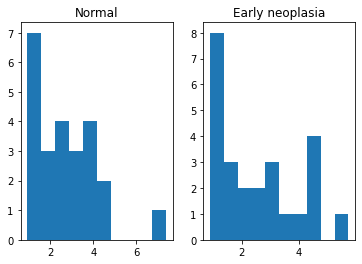

In [5]:
plt.subplot(1,2,1)
plt.title("Normal")
plt.hist(normal["LOC643837"])
plt.subplot(1,2,2)
plt.title("Early neoplasia")
plt.hist(early_neoplasia["LOC643837"])

In [33]:
result = [1 if stats.ttest_ind(normal[column], early_neoplasia[column], equal_var=False)[1] < .05 else 0 for column in normal.columns[2:]]
print(np.unique(np.array(result), return_counts=True))

(array([0, 1]), array([14173,  1575]))


In [34]:
result = [1 if stats.ttest_ind(early_neoplasia[column], cancer[column], equal_var=False)[1] < .05 else 0 for column in normal.columns[2:]]
print(np.unique(np.array(result), return_counts=True))

(array([0, 1]), array([12258,  3490]))


### Часть 2: поправка методом Холма
В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.51.5.

In [35]:
#   Make little refraction to make beautiful tables
#   Adding Fold Change parameter
#   Normal - control; Early - treatment
def fold_change(control: pd.DataFrame, treatment: pd.DataFrame):
    cm = control.mean()
    tm = treatment.mean()
    if tm > cm:
        return tm / cm
    else:
        return -1 * cm / tm

returned_fold_change = list(map(lambda x: fold_change(normal[x],early_neoplasia[x]), normal.columns[2:]))
p_values = [stats.ttest_ind(early_neoplasia[column], normal[column], equal_var=False)[1] for column in normal.columns[2:]]

reject, p_corrected, a1, a2 = sms.multipletests(pvals=p_values, alpha=.025, method="holm")
corrected_normal_early = pd.DataFrame(zip(normal.columns[2:], returned_fold_change, p_values, p_corrected, reject), columns=["GEN", "FOLD_CHANGED", "P", "P_CORRECTED", "REJECT"])
corrected_normal_early.head()

,GEN,FOLD_CHANGED,P,P_CORRECTED,REJECT
0,LOC643837,-1.067858,0.690766,1.000000,False
1,LOC100130417,1.996517,0.000032,0.500174,False
2,SAMD11,1.222418,0.060273,1.000000,False
3,NOC2L,-1.020070,0.826429,1.000000,False
4,KLHL17,1.125471,0.049876,1.000000,False


In [36]:
# Also good way:
#corrected_normal_early[(abs(corrected_normal_early["FOLD_CHANGED"]) > 1.5) & (corrected_normal_early["REJECT"] == True)]
corrected_normal_early[(abs(corrected_normal_early["FOLD_CHANGED"]) > 1.5) & (corrected_normal_early["P_CORRECTED"] <= 0.025)]

,GEN,FOLD_CHANGED,P,P_CORRECTED,REJECT
7244,PCSK4,1.509785,7.955435e-07,0.012527,True
9820,EEF1A2,1.974868,8.498742e-08,0.001338,True


In [44]:
returned_fold_change = list(map(lambda x: fold_change(early_neoplasia[x], cancer[x]), normal.columns[2:]))
p_values = [stats.ttest_ind(early_neoplasia[column], cancer[column], equal_var=False)[1] for column in normal.columns[2:]]
reject, p_corrected, a1, a2 = sms.multipletests(pvals=p_values, alpha=.025, method="holm")
corrected_early_cancer = pd.DataFrame(zip(normal.columns[2:], returned_fold_change, p_values, p_corrected, reject), columns=["GEN", "FOLD_CHANGED", "P", "P_CORRECTED", "REJECT"])
corrected_early_cancer.head()

,GEN,FOLD_CHANGED,P,P_CORRECTED,REJECT
0,LOC643837,-1.148593,0.413735,1.0,False
1,LOC100130417,-1.064871,0.653429,1.0,False
2,SAMD11,1.278517,0.079556,1.0,False
3,NOC2L,1.092635,0.287581,1.0,False
4,KLHL17,1.036574,0.463292,1.0,False


In [45]:
# Also good way:
#corrected_normal_early[(abs(corrected_normal_early["FOLD_CHANGED"]) > 1.5) & (corrected_normal_early["REJECT"] == True)]
corrected_early_cancer[(abs(corrected_early_cancer["FOLD_CHANGED"]) > 1.5) & (corrected_early_cancer["P_CORRECTED"] < 0.025)].shape

(77, 5)

In [42]:
#   Make little refraction to make beautiful tables
#   Adding Fold Change parameter
#   Normal - control; Early - treatment

returned_fold_change = list(map(lambda x: fold_change(normal[x],early_neoplasia[x]), normal.columns[2:]))
p_values = [stats.ttest_ind(early_neoplasia[column], normal[column], equal_var=False)[1] for column in normal.columns[2:]]

reject, p_corrected, a1, a2 = sms.multipletests(pvals=p_values, alpha=.025, method="fdr_bh")
corrected_normal_early = pd.DataFrame(zip(normal.columns[2:], returned_fold_change, p_values, p_corrected, reject), columns=["GEN", "FOLD_CHANGED", "P", "P_CORRECTED", "REJECT"])
corrected_normal_early.head()

,GEN,FOLD_CHANGED,P,P_CORRECTED,REJECT
0,LOC643837,-1.067858,0.690766,0.966511,False
1,LOC100130417,1.996517,0.000032,0.035698,False
2,SAMD11,1.222418,0.060273,0.536103,False
3,NOC2L,-1.020070,0.826429,0.980777,False
4,KLHL17,1.125471,0.049876,0.499016,False


In [41]:
# Also good way:
#corrected_normal_early[(abs(corrected_normal_early["FOLD_CHANGED"]) > 1.5) & (corrected_normal_early["REJECT"] == True)]
corrected_normal_early[(abs(corrected_normal_early["FOLD_CHANGED"]) > 1.5) & (corrected_normal_early["P_CORRECTED"] <= 0.025)]


,GEN,FOLD_CHANGED,P,P_CORRECTED,REJECT
7244,PCSK4,1.509785,7.955435e-07,0.012527,True
9820,EEF1A2,1.974868,8.498742e-08,0.001338,True


In [46]:
returned_fold_change = list(map(lambda x: fold_change(early_neoplasia[x], cancer[x]), normal.columns[2:]))
p_values = [stats.ttest_ind(early_neoplasia[column], cancer[column], equal_var=False)[1] for column in normal.columns[2:]]
reject, p_corrected, a1, a2 = sms.multipletests(pvals=p_values, alpha=.025, method="fdr_bh")
corrected_early_cancer = pd.DataFrame(zip(normal.columns[2:], returned_fold_change, p_values, p_corrected, reject), columns=["GEN", "FOLD_CHANGED", "P", "P_CORRECTED", "REJECT"])
corrected_early_cancer.head()

,GEN,FOLD_CHANGED,P,P_CORRECTED,REJECT
0,LOC643837,-1.148593,0.413735,0.675195,False
1,LOC100130417,-1.064871,0.653429,0.836406,False
2,SAMD11,1.278517,0.079556,0.288873,False
3,NOC2L,1.092635,0.287581,0.563007,False
4,KLHL17,1.036574,0.463292,0.712214,False


In [47]:
# Also good way:
#corrected_normal_early[(abs(corrected_normal_early["FOLD_CHANGED"]) > 1.5) & (corrected_normal_early["REJECT"] == True)]
corrected_early_cancer[(abs(corrected_early_cancer["FOLD_CHANGED"]) > 1.5) & (corrected_early_cancer["P_CORRECTED"] < 0.025)]

,GEN,FOLD_CHANGED,P,P_CORRECTED,REJECT
8,ISG15,2.458867,7.402400e-04,0.017556,True
47,GABRD,1.843860,2.276043e-07,0.000086,True
75,AJAP1,-1.567814,7.993294e-04,0.018270,True
104,CA6,-1.736762,7.806213e-04,0.018078,True
127,MASP2,-1.750200,9.522413e-05,0.005049,True
...,...,...,...,...,...
15640,GPC3,-1.870434,5.832350e-07,0.000156,True
15654,NCRNA00086,-1.615783,4.875591e-04,0.013193,True
15692,BGN,1.763462,1.779494e-04,0.007186,True
15694,DUSP9,-2.173490,2.069987e-04,0.007799,True
